# Introduction
Dans ce second notebook, on cherche à implémenter chacune des étapes du format JPEG. Ce notebook a donc été mis en place pour représenter les fonctions imaginées par notre groupe afin de réaliser la conversion JPEG selon notre compréhension des étapes. ¨Pour réaliser nos tests, nous allons utiliser une image de 637 pixels de largeur, 861 pixels de hauteur et utilisant les 3 canaux de couleur (R,G,B). Nous retrouvons ces informations ci-dessous. Nous réprésentons l'image comme une matrice de pixels.

In [4]:
from PIL import Image
import numpy as np
from PIL import ImageOps
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt
!pip install huffman # ou !pip3 install huffman
!pip install bitarray # ou !pip3 install bitarray
import io
import os

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


# Partie 1: Traitement des couleurs

## Ouverture de l'image

In [5]:
# Charger l'image RGB
image_path = './Image1.png'
try:
    image = Image.open(image_path)
except FileNotFoundError:
    print(f"Erreur : Fichier '{image_path}' introuvable.")

# Convertir l'image en une matrice NumPy de pixels
matrice_pixel = np.array(image)
print("Dimensions de la matrice des pixels:" , matrice_pixel.shape)


Dimensions de la matrice des pixels: (637, 861, 3)


## Conversion modèle RGB vers YCbCr
L'image originale est généralement enregistrée dans le format RGB, qui utilise trois canaux pour représenter les couleurs. La première étape consiste à convertir l'image en espace colorimétrique YCbCr, où le canal Y (luminance) représente l'information de luminosité, tandis que les canaux Cb et Cr (chrominance) contiennent l'information de couleur. Cette conversion simplifie le processus de compression car elle sépare la luminance et la chrominance.

In [6]:
def rgb_to_ycbcr(rgb_image):
    # Convertir une image RGB en espace colorimétrique YCbCr
    if rgb_image.mode != 'RGB':
        raise ValueError("L'image doit être en mode RGB.")

    # Extraire les canaux RGB
    r, g, b = rgb_image.split()

    # Convertir en tableaux NumPy
    r_array = np.array(r, dtype=np.float32)
    g_array = np.array(g, dtype=np.float32)
    b_array = np.array(b, dtype=np.float32)

    # Appliquer la conversion YCbCr
    y_array = 0.299 * r_array + 0.587 * g_array + 0.114 * b_array
    cb_array = 128 - 0.1687 * r_array - 0.3313 * g_array + 0.5 * b_array
    cr_array = 128 + 0.5 * r_array - 0.419 * g_array - 0.081 * b_array

    # Limiter les valeurs aux plages valides
    y_array = np.clip(y_array, 0, 255)
    cb_array = np.clip(cb_array, 0, 255)
    cr_array = np.clip(cr_array, 0, 255)

    # Regrouper les canaux Y, Cb, Cr
    ycbcr_array = np.stack((y_array, cb_array, cr_array), axis=-1)

    # Convertir les valeurs en entiers non signés 8 bits
    ycbcr_array = ycbcr_array.astype('uint8')

    # Créer une image YCbCr à partir du tableau NumPy
    ycbcr_image = Image.fromarray(ycbcr_array)

    return ycbcr_image

# Appliquer la conversion et le sous-échantillonnage
ycbcr_image = rgb_to_ycbcr(image)

# Convertir en tableau NumPy
ycbcr_array = np.array(ycbcr_image)

# Définir la taille du bloc
block_size = 2

# Obtenez la hauteur et la largeur de l'image
height, width, _ = ycbcr_array.shape

# Créer une copie de l'image pour stocker le résultat
ycbcr_array_averaged = ycbcr_array.copy()

# Diviser l'image en blocs 2x2 et faire la moyenne des pixels pour chaque bloc
for i in range(0, height, block_size):
    for j in range(0, width, block_size):
        # Extraire un bloc 2x2 de l'image Y
        block = ycbcr_array[i:i+block_size, j:j+block_size, 0]

        # Calculer la moyenne des pixels dans le bloc
        average_value = np.mean(block)

        # Remplacer tous les pixels du bloc par la moyenne calculée
        ycbcr_array_averaged[i:i+block_size, j:j+block_size, 0] = average_value


ycbcr_array = ycbcr_array_averaged

## Sous-echantillonage chrominance
Les canaux Cb et Cr sont souvent sous-échantillonnés (diminution de la résolution) par rapport au canal Y, car la perception humaine est plus sensible à la luminance qu'à la chrominance. Cela réduit la quantité d'information à traiter.

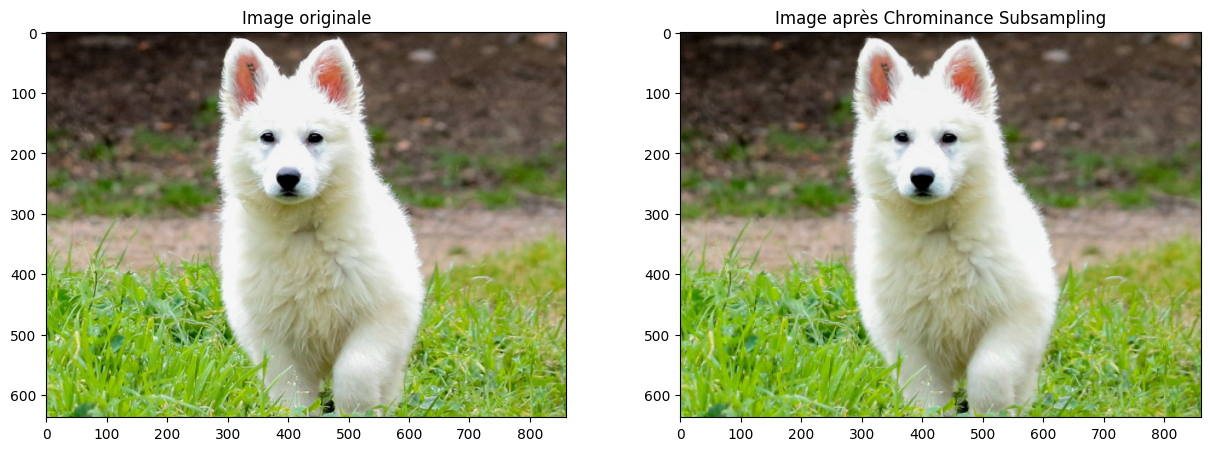

In [7]:

ycbcr_image_after_subsampling = Image.fromarray(ycbcr_array.astype(np.uint8), 'YCbCr')

# Créer une figure avec 1 ligne et 3 colonnes
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Afficher l'image originale
axes[0].imshow(image)
axes[0].set_title('Image originale')

# Afficher l'image après sous-échantillonnage de chrominance
axes[1].imshow(ycbcr_image_after_subsampling)
axes[1].set_title('Image après Chrominance Subsampling')

plt.show()


# Partie 2 : Traitement de signal , de hautes fréquences et encodeur jpeg

## Centralisation sur 128
Pour faciliter la représentation des coefficients DCT (Transformée en cosinus discrète), la valeur moyenne de 128 est soustraite de tous les pixels. Cela recentre les valeurs autour de zéro.

In [8]:
def centralisation(ycbcr_array):
    # Créer une matrice de soustraction de 128 avec la même forme que ycbcr_array
    soustraction_128 = np.full_like(ycbcr_array, 128, dtype=int)

    # Soustraire individuellement 128 à chaque valeur
    ycbcr_centralized = ycbcr_array - soustraction_128

    # Afficher la matrice des pixels d'origine
    #print("Matrice des pixels d'origine:")
    #print(ycbcr_array)
    # Afficher la matrice des pixels centrée
    #print("\nMatrice des pixels centrée:")
    #print(ycbcr_centralized)
    return ycbcr_centralized

# Appeler la fonction avec votre ycbcr_array
ycbcr_array = centralisation(ycbcr_array)

## Application de la DCT
Chaque bloc de l'image est transformé en utilisant la DCT, qui permet de représenter l'information dans le domaine fréquentiel. Les coefficients DCT représentent la contribution de différentes fréquences spatiales dans chaque bloc.

In [9]:
def generate_P(N):
    dct_matrix = np.zeros((N, N))
    for u in range(N):
        for x in range(N):
            if u == 0:
                dct_matrix[u, x] = 1 / np.sqrt(N)
            else:
                dct_matrix[u, x] = np.sqrt(2/N) * np.cos((2*x + 1) * u * np.pi / (2 * N))
    return np.transpose(dct_matrix)

def apply_dct(ycbcr_dct):
    height, width, channels = ycbcr_dct.shape
    # Ajuster height et width pour qu'ils soient des multiples de 8
    height = (height // 8) * 8
    width = (width // 8) * 8

    F = np.zeros((height, width, channels))
    for channel in range(channels):
        for i in range(0, height, 8):
            for j in range(0, width, 8):
                # Extraire un bloc 8x8 de coefficients DCT
                block = ycbcr_dct[i:min(i+8, height), j:min(j+8, width), channel]

                # Ajuster la taille de P à la taille du bloc
                P = generate_P(8)

                P_adjusted = P[:block.shape[0], :block.shape[1]]
                # Ajuster la taille du bloc à 8x8
                adjusted_block = np.zeros((8, 8))
                adjusted_block[:block.shape[0], :block.shape[1]] = block

                # Calcule F associé au bloc
                F[i:i+8, j:j+8, channel] = P.T @ adjusted_block @ P

    return F



## Quantification
 Les coefficients DCT sont quantifiés en réduisant la précision de certains coefficients. Pour cela on divise par une matrice de quantification que nous avons contruite, ce qui permet de représenter l'image de manière plus compacte

In [10]:

import huffman
from collections import defaultdict

def quantize_dct(F, quantization_matrix_Y, quantization_matrix_cbcr):
    height, width, channels = F.shape
    quantized_F = np.zeros_like(F)

    for channel in range(channels):
        quantization_matrix = quantization_matrix_Y if channel == 0 else quantization_matrix_cbcr

        for i in range(0, height, 8):
            for j in range(0, width, 8):
                # Extraire un bloc 8x8 de coefficients F
                block = F[i:i+8, j:j+8, channel]

                # Diviser chaque élément du bloc par l'inverse de la matrice de quantification
                quantized_block_float = block / quantization_matrix
                quantized_block = quantized_block_float.astype(int)

                # Assigner le bloc quantifié à la matrice résultante
                quantized_F[i:i+8, j:j+8, channel] = quantized_block

    return quantized_F


import numpy as np

def generate_quantization_matrix(K, size=8):
    quantization_matrix = np.zeros((size, size))

    for i in range(size):
        for j in range(size):
            quantization_matrix[i, j] = 1 + K * (i + j + 1)

    return quantization_matrix

ModuleNotFoundError: No module named 'huffman'

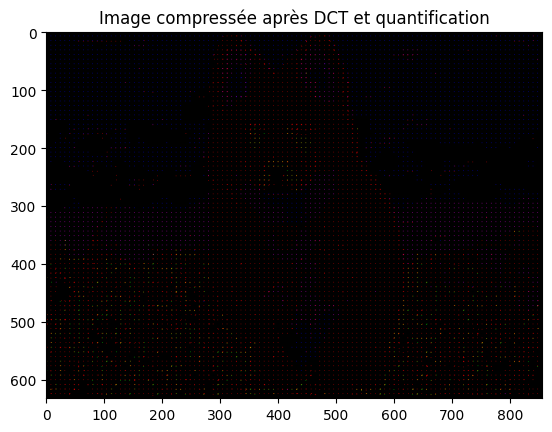

In [ ]:

result_dct = apply_dct(ycbcr_array)
# Exemple d'utilisation de la quantification
K = 1  # Valeur de K (facteur de qualité)  en variant la valeur de K , l'image final est modifiée : plus K est grand , plus l'image est très compréssé
quantization_matrix = generate_quantization_matrix(K)
quantization_matrix_y = generate_quantization_matrix(25) # si on augmente image final se dégrade très vite
quantization_matrix_c = generate_quantization_matrix(25) # partie cb cr pas de dégradation rapide
quantized_result = quantize_dct(result_dct, quantization_matrix_y, quantization_matrix_c)

# Afficher l'image comprimée après DCT et quantification
plt.imshow(quantized_result)
plt.title("Image compressée après DCT et quantification")
plt.show()
np.save('quantized_data.npy', quantized_result)


Cela nécessite un effort visuel, mais on peut remarquer que des points de couleurs apparaissent. On comprend ici qu'une grande partie des coefficients vaut 0 et que les fréquences qui impactent la formation des bloc sont finalement peu parmi les 64 possibilités.

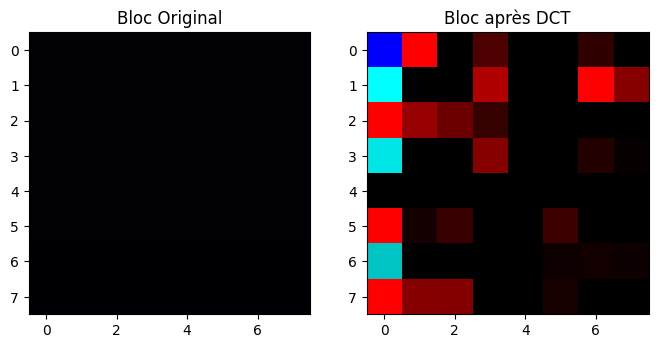

In [ ]:
# Sélectionner un bloc 8x8 de l'image (ici, supposons que le bloc est dans le coin supérieur gauche)
block = ycbcr_array[:8, :8]

# Appliquer la DCT au bloc sélectionné
dct_block = apply_dct(block)

# Afficher le bloc original et le bloc après DCT
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(block)
plt.title('Bloc Original')

plt.subplot(1, 2, 2)
plt.imshow(dct_block)
plt.title('Bloc après DCT')

plt.show()

## Encodage huffman
Un codage entropique, sans distorsion, est enfin réalisé permettant d'utiliser les propriétés statistiques des images. On commence par ordonner les coefficients suivant un balayage en zigzag pour placer d'abord les coefficients correspondant aux fréquences les plus basses. Cela donne une suite de symboles. Le code de Huffman consiste à représenter les symboles les  plus probables par des codes comportant un nombre de bits le plus petit possible.

In [ ]:
import numpy as np
from collections import Counter
import huffman

def zigzag_scan(matrix):
    k, n, l = matrix.shape
    result = np.zeros(k * n * l, dtype=matrix.dtype)

    for i in range(k):
        for j in range(n):
            for z in range(l):
                index = i * n * l + j * l + z
                result[index] = matrix[i, j, z]

    return result

def huffman_encode(data):
    counter = Counter(data)
    probabilities = {sym: count / len(data) for sym, count in counter.items()}

    # Conversion des poids des symboles en une liste
    symbol_weights = list(probabilities.items())

    # Création de l'arbre de Huffman
    huff_tree = huffman.codebook(symbol_weights)

    # Création d'un dictionnaire de codes Huffman
    huffman_dict = {sym: huff_tree[sym] for sym in counter.keys()}

    # Encodage des données avec les codes Huffman
    encoded_data = ''.join([huffman_dict[sym] for sym in data])

    return encoded_data, huffman_dict


def entropy_coding(image_array):
    k, n, l = image_array.shape

    # Balayage en zigzag
    zigzagged_array = zigzag_scan(image_array)

    # Codage de Huffman
    flattened_array = zigzagged_array.flatten()
    encoded_data, huffman_dict = huffman_encode(flattened_array)

    return encoded_data, huffman_dict


def save_to_bin(encoded_data, output_file):
    with open(output_file, 'wb') as file:
        file.write(encoded_data.encode('utf-8'))

def load_from_bin(input_file):
    with open(input_file, 'rb') as file:
        encoded_data = file.read().decode('utf-8')
    return encoded_data


# Codage entropique
encoded_data, huffman_dict = entropy_coding(quantized_result)

# Affichage des résultats
print("Image array shape:", quantized_result.shape)
print("Encoded data:", encoded_data)
print("Huffman dictionary:", huffman_dict)

# Enregistrement dans un fichier binaire
output_file = 'encoded_data.bin'
save_to_bin(encoded_data, output_file)

# Chargement depuis le fichier binaire
loaded_encoded_data = load_from_bin(output_file)


Image array shape: (632, 856, 3)
Encoded data: 01111110010001101001111111111111111111110111111001000110100111111111111111111111011111100110111010011111111111111111111101111110011001001101001111111111111111111110111111001100100110100111111111111111111111011111100110110011010011111111111111111111101111110011011001101001111111111111111111110111111001110011010011111111111111111111101111110010001101001111111111111111111110111111001110011010011111111111111111111101100001010011010011111111111111111111100100110010011010011111111111111111111100100110010011111111111111111111111101111110010001111111111111111111111110111111001000110100111111111111111111111011000010100110100111111111111111111111011111100100011010011111111111111111111101111110011011001101001111111111111111111110111111001111010011111111111111111111101111110011110100111111111111111111111011111100111101001111111111111111111110111111001111010011111111111111111111101111110011110100111111111111111111111011000010110100111111111111111111111

# Partie 3 : Décompression et lecture du *JPEG*
Pour restaurer l'image d'origine à partir d'un fichier JPEG compressé, le processus de décompression nécessite l'application des étapes inverses de la compression.

## Decodage Huffman


In [ ]:
import numpy as np

def huffman_decode(encoded_data, huffman_dict):
    reversed_dict = {code: sym for sym, code in huffman_dict.items()}
    decoded_data = ''
    current_code = ''

    for bit in encoded_data:
        current_code += bit
        if current_code in reversed_dict:
            decoded_data += str(reversed_dict[current_code]) + ' '
            current_code = ''

    # Si le dernier code n'a pas été entièrement décodé, ajoute tel quel
    if current_code:
        decoded_data += str(reversed_dict[current_code]) + ' '

    return decoded_data


def zigzag_inverse_scan(array, shape):
    k, n, l = shape
    result = np.zeros(shape, dtype=array.dtype)

    for i in range(k):
        for j in range(n):
            for z in range(l):
                index = i * n * l + j * l + z
                result[i, j, z] = array[index]

    return result

def entropy_decoding(encoded_data, huffman_dict, shape):
    # Decoding Huffman
    decoded_data = huffman_decode(encoded_data, huffman_dict)

    # Dezigzag inverse
    decoded_array = zigzag_inverse_scan(np.array(list(map(float, decoded_data.rstrip().split()))), shape)


    decoded_array = decoded_array.astype(int)

    return decoded_array


# Chargement des données depuis le fichier binaire
loaded_encoded_data = load_from_bin(output_file)

# Décodage entropique
decoded_array = entropy_decoding(loaded_encoded_data, huffman_dict, quantized_result.shape)

# Affichage des résultats après décodage
print("ARRAY BASE:", quantized_result)
print("Decoded array:", decoded_array)

# Comparaison des matrices
are_matrices_equal = np.array_equal(quantized_result, decoded_array)
print("Are matrices equal?", are_matrices_equal)

ARRAY BASE: [[[-32.  -1.   1.]
  [  0.   0.   0.]
  [  0.   0.   0.]
  ...
  [  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]]

 [[  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]
  ...
  [  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]]

 [[  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]
  ...
  [  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]]

 ...

 [[  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]
  ...
  [  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]]

 [[  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]
  ...
  [  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]]

 [[  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]
  ...
  [  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]]]
Decoded array: [[[-32  -1   1]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0 

## Inverse quantification

In [ ]:
def dequantize_dct(quantized_F, quantization_matrix_Y, quantization_matrix_cbcr):
    height, width, channels = quantized_F.shape
    dequantized_F = np.zeros_like(quantized_F, dtype=float)

    for channel in range(channels):
        quantization_matrix = quantization_matrix_Y if channel == 0 else quantization_matrix_cbcr

        for i in range(0, height, 8):
            for j in range(0, width, 8):
                # Extraire un bloc 8x8 de coefficients F quantifiés
                quantized_block = quantized_F[i:i+8, j:j+8, channel]

                # Multiplication par la matrice de quantification
                dequantized_block = quantized_block * quantization_matrix

                # Assigner le bloc déquantifié à la matrice résultante
                dequantized_F[i:i+8, j:j+8, channel] = dequantized_block

    return dequantized_F


## Application de la DCT inverse DCT-3

In [ ]:
def inverse_dct(F):
    height, width, channels = F.shape
    ycbcr_array_reconstructed = np.zeros((height, width, channels))

    for channel in range(channels):
        for i in range(0, height, 8):
            for j in range(0, width, 8):
                # Extraire un bloc 8x8 de coefficients DCT inversés
                block = F[i:i+8, j:j+8, channel]

                # Utiliser la matrice inverse de la DCT
                inverse_P = np.linalg.inv(generate_P(8))

                # Calculer l'image spatiale associée au bloc
                spatial_block = inverse_P.T @ block @ inverse_P

                # Assigner le bloc reconstruit à l'image spatiale résultante
                ycbcr_array_reconstructed[i:i+8, j:j+8, channel] = spatial_block

    return ycbcr_array_reconstructed

## Décentralisation

In [ ]:
def decentralisation(ycbcr_array):
    #Créer une matrice d'addition de 128 avec la même forme que ycbcr_array
    addition_128 = np.full_like(ycbcr_array, 128, dtype=int)

    # Ajouter individuellement 128 à chaque valeur
    ycbcr_centralized = ycbcr_array + addition_128

    return ycbcr_centralized

In [ ]:
def ajuster_taille_matrice(matrice_source, matrice_cible):
    hauteur, largeur, _ = matrice_cible.shape
    matrice_resultat = np.zeros_like(matrice_cible)
    matrice_resultat = matrice_source[:hauteur, :largeur, :]

    return matrice_resultat


#Partie 4 : Affichage de la nouvelle image

On propose dans cette partie d'utiliser les fonctions imaginées par notre groupe pour visualiser des images de différentes tailles, contenus, et type.
Pour cela on propose aux utilisateurs de choisir une image et de rentrer son chemin dans la variable global puis de lancer le notebook.

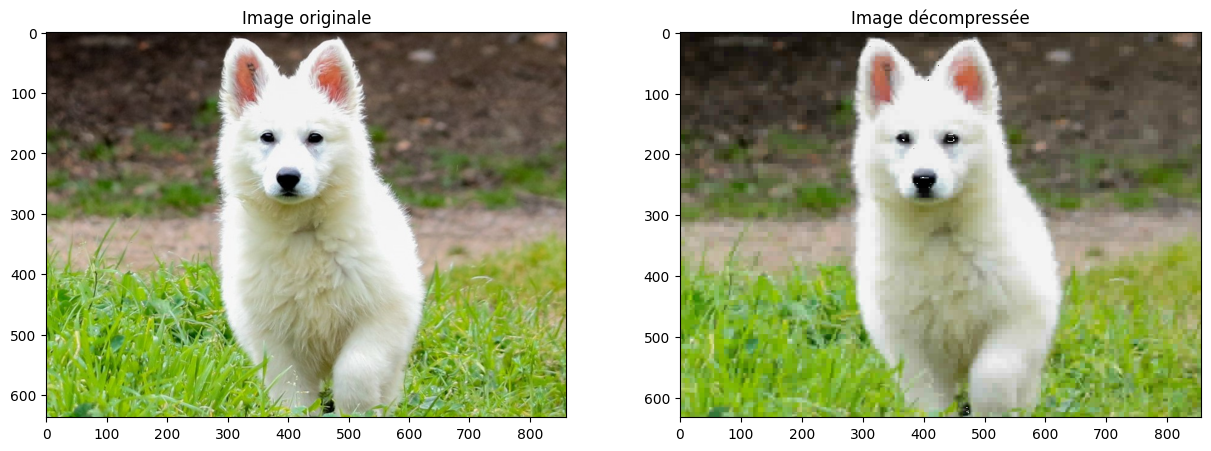

<Figure size 1000x500 with 0 Axes>

In [ ]:
# Déquantifier les coefficients DCT
dequantized_result = dequantize_dct(decoded_array, quantization_matrix_y, quantization_matrix_c)

# Reconstruire l'image spatiale
reconstructed_image = inverse_dct(dequantized_result)

# Centraliser l'image décompressée
ycbcr_decentralized = decentralisation(reconstructed_image)


# Ajuster la taille de la matrice si nécessaire
ycbcr_final = ajuster_taille_matrice(ycbcr_decentralized, ycbcr_array)

# Créer une image à partir de la matrice décentralisée
image_to_save = Image.fromarray(ycbcr_final.astype(np.uint8), mode='YCbCr')


# Créer une figure avec 1 ligne et 3 colonnes
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Afficher l'image originale
axes[0].imshow(image)
axes[0].set_title('Image originale')

# Afficher l'image après sous-échantillonnage de chrominance
axes[1].imshow(image_to_save)
axes[1].set_title('Image décompressée')


# Afficher les deux images côte à côte
plt.figure(figsize=(10, 5))

plt.show()



# Partie 5 : Analyse de la taille de l'image avant et après compression

*Pour* vérifier l'efficacité de notre compression, nous comparons la taille de l'image en mémoire avant et après la compression.

In [ ]:
try:
    # Charger l'image RGB
    image = Image.open(image_path)

    # Obtenir la taille en octets (bytes) de l'image en mémoire
    taille_octets = os.path.getsize(image_path)

    # Convertir la taille en kilo-octets (ko) ou méga-octets (Mo) pour plus de lisibilité
    taille_ko = taille_octets / 1000

    # Afficher les résultats
    print(f"Taille en octets : {taille_octets} octets")
    print(f"Taille en kilo-octets : {taille_ko:.2f} Ko")

except FileNotFoundError:
    print(f"Erreur : Fichier '{image_path}' introuvable.")

from io import BytesIO

# Créer un objet BytesIO
buffer = BytesIO()

# Enregistrer l'image dans l'objet BytesIO
image_to_save.save(buffer, format='JPEG')

# Obtenir la taille du buffer en octets
taille_octets_image = len(buffer.getvalue())

# Convertir la taille en kilo-octets (ko) ou méga-octets (Mo) pour plus de lisibilité
taille_ko_decompressed = taille_octets_image / 1000

# Calculer le taux de compression en pourcentage
compression_ratio_percentage = (1 - (taille_ko_decompressed/ taille_ko)) * 100


# Afficher les résultats
print(f"Taille de l'image décompressée en octets : {taille_octets_image} octets")
print(f"Taille de l'image décompressée en kilo-octets : {taille_ko_decompressed:.2f} Ko")
print(f"Taux de compression : {compression_ratio_percentage:.2f}%")

Taille en octets : 178521 octets
Taille en kilo-octets : 178.52 Ko
Taille de l'image décompressée en octets : 24549 octets
Taille de l'image décompressée en kilo-octets : 24.55 Ko
Taux de compression : 86.25%


En utilisant notre script Python, nous avons évalué la taille du fichier image avant compression à 178521 octets, ce qui équivaut à 174.34 Ko. Après la compression, la taille de l'image décompressée s'est réduite à 24549 octets, soit 23.97 Ko pour un facteur K = 25 pour la matrice de quantification. Ces résultats démontrent une réduction significative de la taille du fichier, avec un taux de compression impressionnant de 86.25\%.